In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sae_fakedata import SparseAutoEncoder
import os
from data_generation import prepare_data, attention_fakedata
from trainAttn_fakedata import SelfAttentionLightning

In [12]:
df_quantized, _ = attention_fakedata(quantize=True,quantization_decimals=2)
# df_nonquantized, _ = attention_fakedata()

(100000, 3)


In [13]:
df_quantized["f1"].unique().shape

(310,)

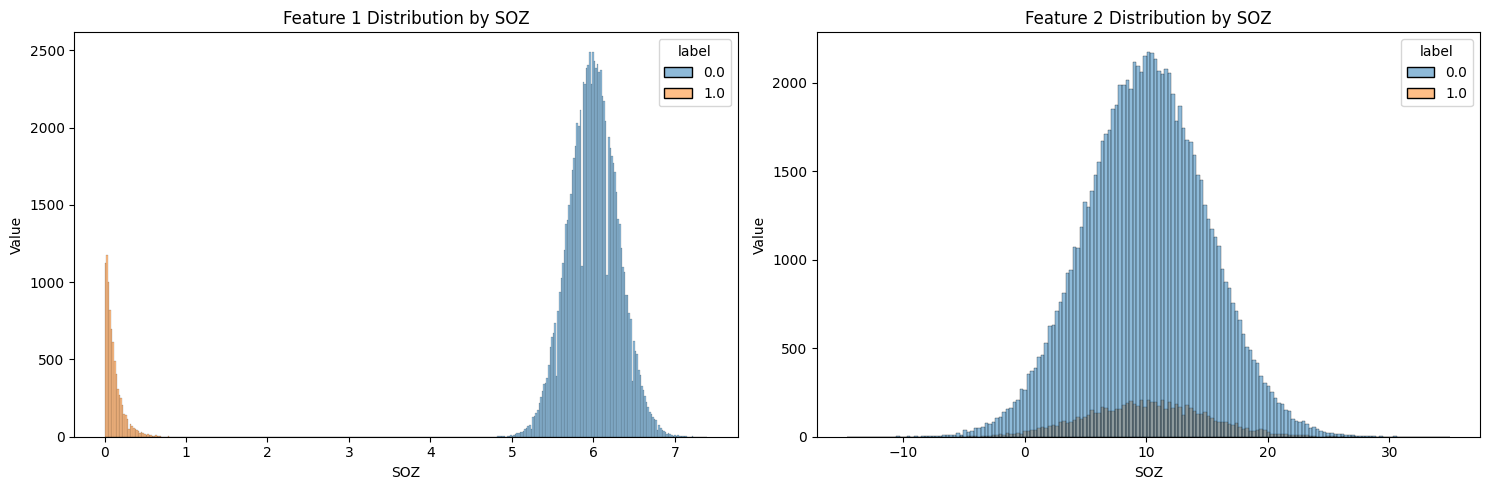

In [14]:

# plot features on one 1,3 plot grouped by label
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature 1 distributions
sns.histplot(data=df_quantized, hue='label', x='f1', ax=axes[0])
axes[0].set_title('Feature 1 Distribution by SOZ')
axes[0].set_xlabel('SOZ')
axes[0].set_ylabel('Value')

# Plot feature 2 distributions  
sns.histplot(data=df_quantized, hue='label', x='f2', ax=axes[1])
axes[1].set_title('Feature 2 Distribution by SOZ')
axes[1].set_xlabel('SOZ')
axes[1].set_ylabel('Value')

# # Plot feature 3 distributions
# sns.histplot(data=raw_df, hue='label', x='f3', ax=axes[2])
# axes[2].set_title('Feature 3 Distribution by SOZ')
# axes[2].set_xlabel('SOZ')
# axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()


In [15]:
# error_1 = (df_quantized['f1'] - df_nonquantized['f1']).abs()
# error_2 = (df_quantized['f2'] - df_nonquantized['f2']).abs()

# print(error_1.mean(), error_2.mean())

In [16]:
def load_sae_and_shape(sae_dir, name):
    """
    Load a trained SAE and its shape information
    """
    # Get the layer directory
    layer_dir = os.path.join(sae_dir, f'sae_{name}')
    
    # Load shape information
    shape_info = torch.load(os.path.join(layer_dir, f'shape_info_{name}.pt'), map_location='cpu')
    
    # Initialize SAE with the saved dimensions
    activation_dim = shape_info['flattened_dim']
    dict_size = activation_dim * 10  # Same multiplier as in training
    
    sae = SparseAutoEncoder(activation_dim, dict_size)
    sae.load_state_dict(torch.load(os.path.join(layer_dir, f'sae_{name}.pt'), map_location='cpu'))
    sae.eval()
    
    return sae, shape_info

In [17]:
# Load the trained attention model
model_save_path = "/media/dan/Data/git/ubiquitous-spork/prediction/src/models/quantized_attention_model_20250401_114748/final_model.ckpt"  # Update this path

# model_save_path = "/media/dan/Data/git/ubiquitous-spork/prediction/src/models/attention_model_20250331_173250/final_model.ckpt"
model = SelfAttentionLightning.load_from_checkpoint(model_save_path, map_location='cpu')
model.eval()

# Load the SAE directory (update this path to your latest SAE training run)
sae_dir = "/media/dan/Data/git/ubiquitous-spork/prediction/src/models/sae_attention_20250401_115935"

# Prepare data
train_dataset, val_dataset, n_features = prepare_data()
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2048,
    shuffle=False,
    num_workers=min(63, os.cpu_count() or 1),
    pin_memory=False  # No need for pin_memory when using CPU
)

# Get a batch of data
with torch.no_grad():
    features, _ = next(iter(train_loader))

# List of layer names to analyze
layer_names = [
    'proj_keys', 'proj_queries', 'proj_values',
    'attn_output', 'attn_weights', 'ln', 'fc1', 'fc2'
]

(100000, 3)


In [30]:
model.attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
)

In [18]:
features.shape

torch.Size([2048, 2])

In [19]:
np.unique(features.numpy()[:,0]).shape # every row is a unique example

(2048,)

In [20]:
name = "proj_queries"
sae, shape_info = load_sae_and_shape(sae_dir, name)

In [21]:
sae

SparseAutoEncoder(
  (encoder_DF): Linear(in_features=6, out_features=60, bias=True)
  (decoder_FD): Linear(in_features=60, out_features=6, bias=True)
)

In [22]:
x = features.unsqueeze(-1)
output = model.proj_queries(x)
output = output.reshape(output.size(0), -1)

In [23]:
output.shape

torch.Size([2048, 6])

Text(0.5, 1.0, 'proj_queries - Decoder Weights')

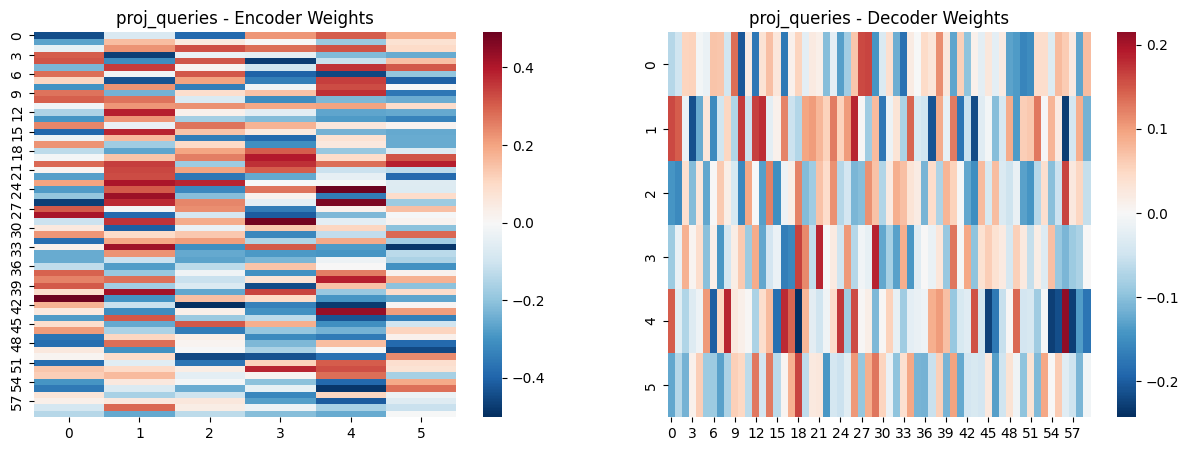

In [24]:
# Get encoder and decoder weights
encoder_weights = sae.encoder_DF.weight.data.numpy()
decoder_weights = sae.decoder_FD.weight.data.numpy()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot encoder weights
sns.heatmap(encoder_weights, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title(f'{name} - Encoder Weights')
# ax1.set_xlabel('Dictionary Size')
# ax1.set_ylabel('Input Dimension')

# Plot decoder weights
sns.heatmap(decoder_weights, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title(f'{name} - Decoder Weights')
# ax2.set_xlabel('Output Dimension')
# ax2.set_ylabel('Dictionary Size')

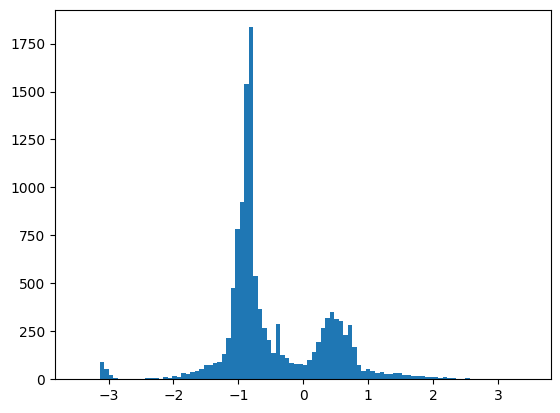

In [25]:
plt.hist(output.detach().numpy().flatten(), bins=100);

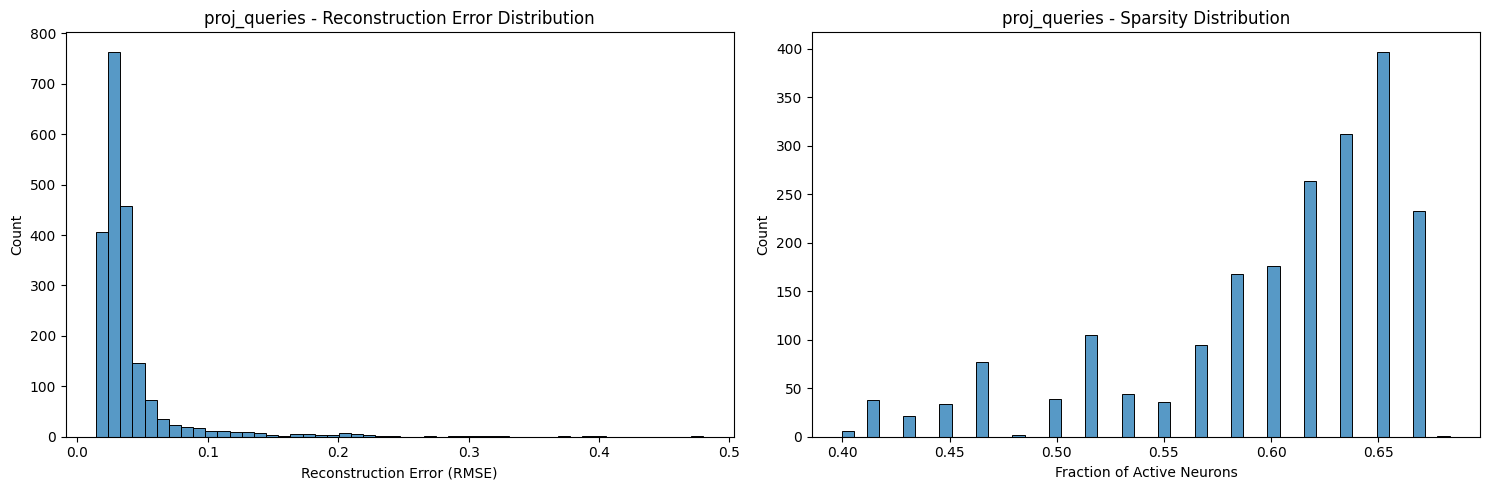

In [26]:
with torch.no_grad():
    reconstructed, encoded = sae.forward_pass(output)
    reconstruction_error = (reconstructed - output).pow(2).mean(dim=1).sqrt() # root mean squared error
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot reconstruction error distribution
    sns.histplot(reconstruction_error.numpy(), ax=ax1, bins=50)
    ax1.set_title(f'{name} - Reconstruction Error Distribution')
    ax1.set_xlabel('Reconstruction Error (RMSE)')
    ax1.set_ylabel('Count')
    
    # Plot sparsity of encoded representation
    sparsity = (encoded > 0).float().mean(dim=1)
    sns.histplot(sparsity.numpy(), ax=ax2, bins=50)
    ax2.set_title(f'{name} - Sparsity Distribution')
    ax2.set_xlabel('Fraction of Active Neurons')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()

In [27]:
# Print some statistics
with torch.no_grad():
    reconstructed, encoded = sae.forward_pass(output)
    reconstruction_error = (reconstructed - output).pow(2).mean().sqrt()
    sparsity = (encoded > 0).float().mean()
    print(f"Reconstruction Error (RMSE): {reconstruction_error:.4f}")
    print(f"Sparsity: {sparsity:.4f}")

Reconstruction Error (RMSE): 0.0557
Sparsity: 0.5998


In [28]:
encoded.shape

torch.Size([2048, 60])